# Linear dynamical system model of the somatosensory workingmemory task (Figure 5)

This notebook has 4 sections:

* Load libraries and functions
* Optimize LDS
* Some visualisations of the opimization results
* Generation of model data from optimized LDS, as presented in figure 5

# Load libraries and functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

%matplotlib notebook

In [28]:
def give_shift_matrix(n_x):
    # Shift matrix, used to shift histories
    S = np.zeros((n_x,n_x))
    S[1:,:-1] = np.eye(n_x-1)
    return S

def phi_var(A,B,C,M):
    
    N = A.shape[0]
    Phi = torch.zeros(N,M)
    var_z = torch.eye(N)

    ApB = B
    AAt = torch.eye(N)
    Phi[:,:1] = B
    for m in range(1,M):
        ApB = A.mm(ApB)
        Phi[:,m:m+1] = ApB
        
        AAt = A.mm(AAt).mm(A.t())
        var_z = var_z + AAt

    var = C.mm(var_z).mm(C.t())
    
    return Phi, var

def give_obs(s_times, t, obs):
    
    for sti, st in enumerate(s_times):
        if t >= st[0] and t < st[1]:
            return obs[sti]
    return 0

def sim_1_trial(T, s_times, f1_f2, A, B, N, sig_trans, decay=True):

    X = np.zeros((N, T))

    s = give_obs(s_times, 0, f1_f2)

    X[:,0] = B * s
    
    Dec = np.eye(A.shape[0]) * 0.6 # Matrix for decaying state artificially, after f_2 presentation
    f_stop = s_times[-1][-1]

    for n in range(1, T):
        s = give_obs(s_times, n, f1_f2)

        if n >= f_stop and decay:
            X[:,n] = Dec.dot(X[:,n-1]) + B * s + np.random.randn() * sig_trans
        else:
            X[:,n] = A.dot(X[:,n-1]) + B * s + np.random.randn() * sig_trans
        
    return X

# Optimization

The following cell optimizes the LDS. It takes around 20 minutes with the given parameters (on a macbook pro). 

In [19]:
### This cell runs the LDS optimization

T_D = 15 # number of trial time steps
N_z = 15 # number of Z-dimensions

## define inputs (times of f_1 and f_2 presentation):
stim_list = []
stim_list.append([1,2]) # f1 time
stim_list.append([T_D-1,T_D]) # f2 time
n_stim = len(stim_list)

## Pre-compute some objects to speed up optimization:
# M maps inputs to decision time history, i.e. h_{T_D} = M * [f1; f2]
M = torch.zeros(T_D, n_stim) 
for i in range(n_stim):
    M[stim_list[i][0]:stim_list[i][1], i] = 1
M = M.flip(0)

# Matrix with all histories as rows. These are the maximum length histories, used to compute z <= z_max
S = torch.tensor(give_shift_matrix(T_D), dtype=torch.float)
Hmax = torch.zeros(T_D,T_D)
Hmax[:1,:] = M.mm(torch.ones(n_stim,1)).t()
for m in range(1,T_D):
    Hmax[m:m+1,:] = Hmax[m-1:m,:].mm(S)
Hmax /= np.sqrt(torch.diag(Hmax.t().mm(Hmax))).max()

# for f1-f2 readout:
I = torch.tensor([1, -1]).view(1,-1) 

## Initialize parameters:
torch.manual_seed(0)
C = torch.randn(1, N_z, requires_grad=True) # for (f1-f2) readout
C.data *= 0.1
A = torch.randn(N_z,N_z, requires_grad=True)
A.data *= 0.1
B = torch.rand(N_z,1, requires_grad=True)

## Set up optimizer:
nitr = 4*int(1e5) # number of trainig iterations
alpha = 1e-4 # learning rate
optimizer = optim.Adam([{'params': A, "lr": alpha},
                        {'params': B, "lr": alpha},
                        {'params': C, "lr": alpha}], lr=alpha, amsgrad=False)

## Transition noise:
sig_trans = 0.1

## Optimize:
L = []
for i in range(nitr):
    
    # lower learning rate half way through optimization
    if (i+1)%int(nitr/2) == 0:
        alpha *= 0.1
        optimizer = optim.Adam([{'params': A, "lr": alpha},
                                {'params': B, "lr": alpha},
                                {'params': C, "lr": alpha}], lr=alpha, amsgrad=False)
    

    # compute Phi and readout variance 
    Phi, var_readout = phi_var(A,B,C,T_D)
    var = sig_trans**2 * var_readout

    lm = ((I - C.mm(Phi).mm(M))**2).sum()/(2*var) # max loglik solution for f1-f2 represent
    lv = torch.log(var)/2 
    PhiH = Phi.mm(Hmax)
    lb = torch.sum((PhiH-1).clamp(0)) # loss for violating upper bound
    ln = torch.sum((-Phi-0).clamp(0)) # loss for violating lower bound
    
    loss = lm + lv + lb + ln
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%100 == 0:
        L.append([lm.item(), lv.item(), lb.item(), ln.item()])
        if i%int(nitr/10) == 0:
            print(loss.item())
    


513.173095703125
0.5020862221717834
-1.9645978212356567
-2.171658754348755
-2.199141025543213
-2.2055294513702393
-2.2117459774017334
-2.2122273445129395
-2.212491512298584
-2.212662935256958


## Plot loss

<IPython.core.display.Javascript object>


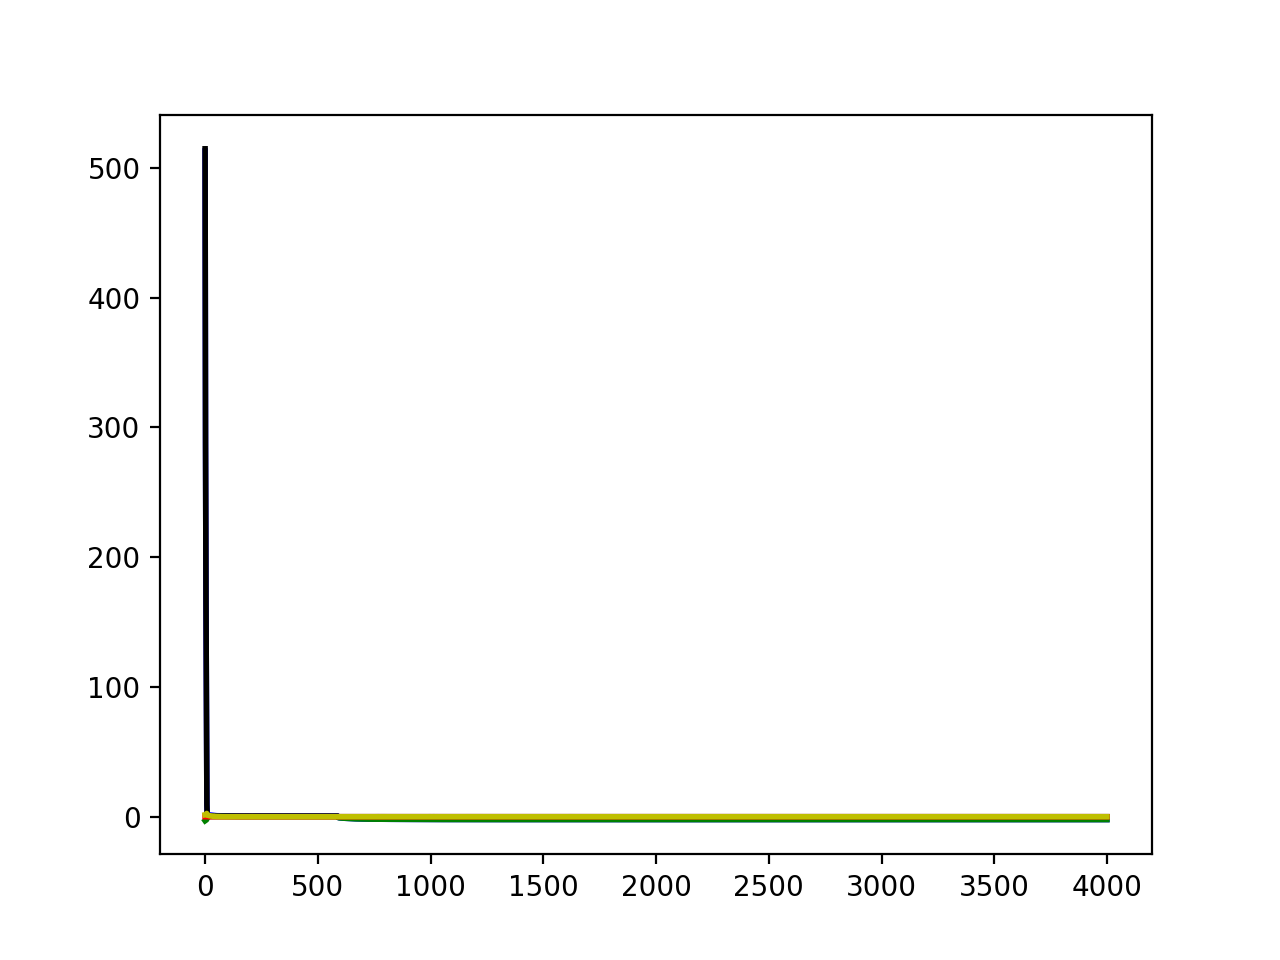

In [20]:
L = np.array(L)
plt.figure()
plt.plot(L.sum(axis=1), "b", linewidth=2)
plt.plot(L[:,0], "k", linewidth=2) # "mean" part of the log-likelihood
plt.plot(L[:,1], "g", linewidth=2) # "variance" part of the log-likelihood
plt.plot(L[:,2], "r", linewidth=2) # loss for violating upper bound
plt.plot(L[:,3], "y", linewidth=2) # loss for violating lower bound

# Visualization of optimization results

Note for example that the input weights feed only into a subset of the dimensions. Similarly, the readout weights cluster into negative $c_-$ and positive $c_+$ weights.

<IPython.core.display.Javascript object>


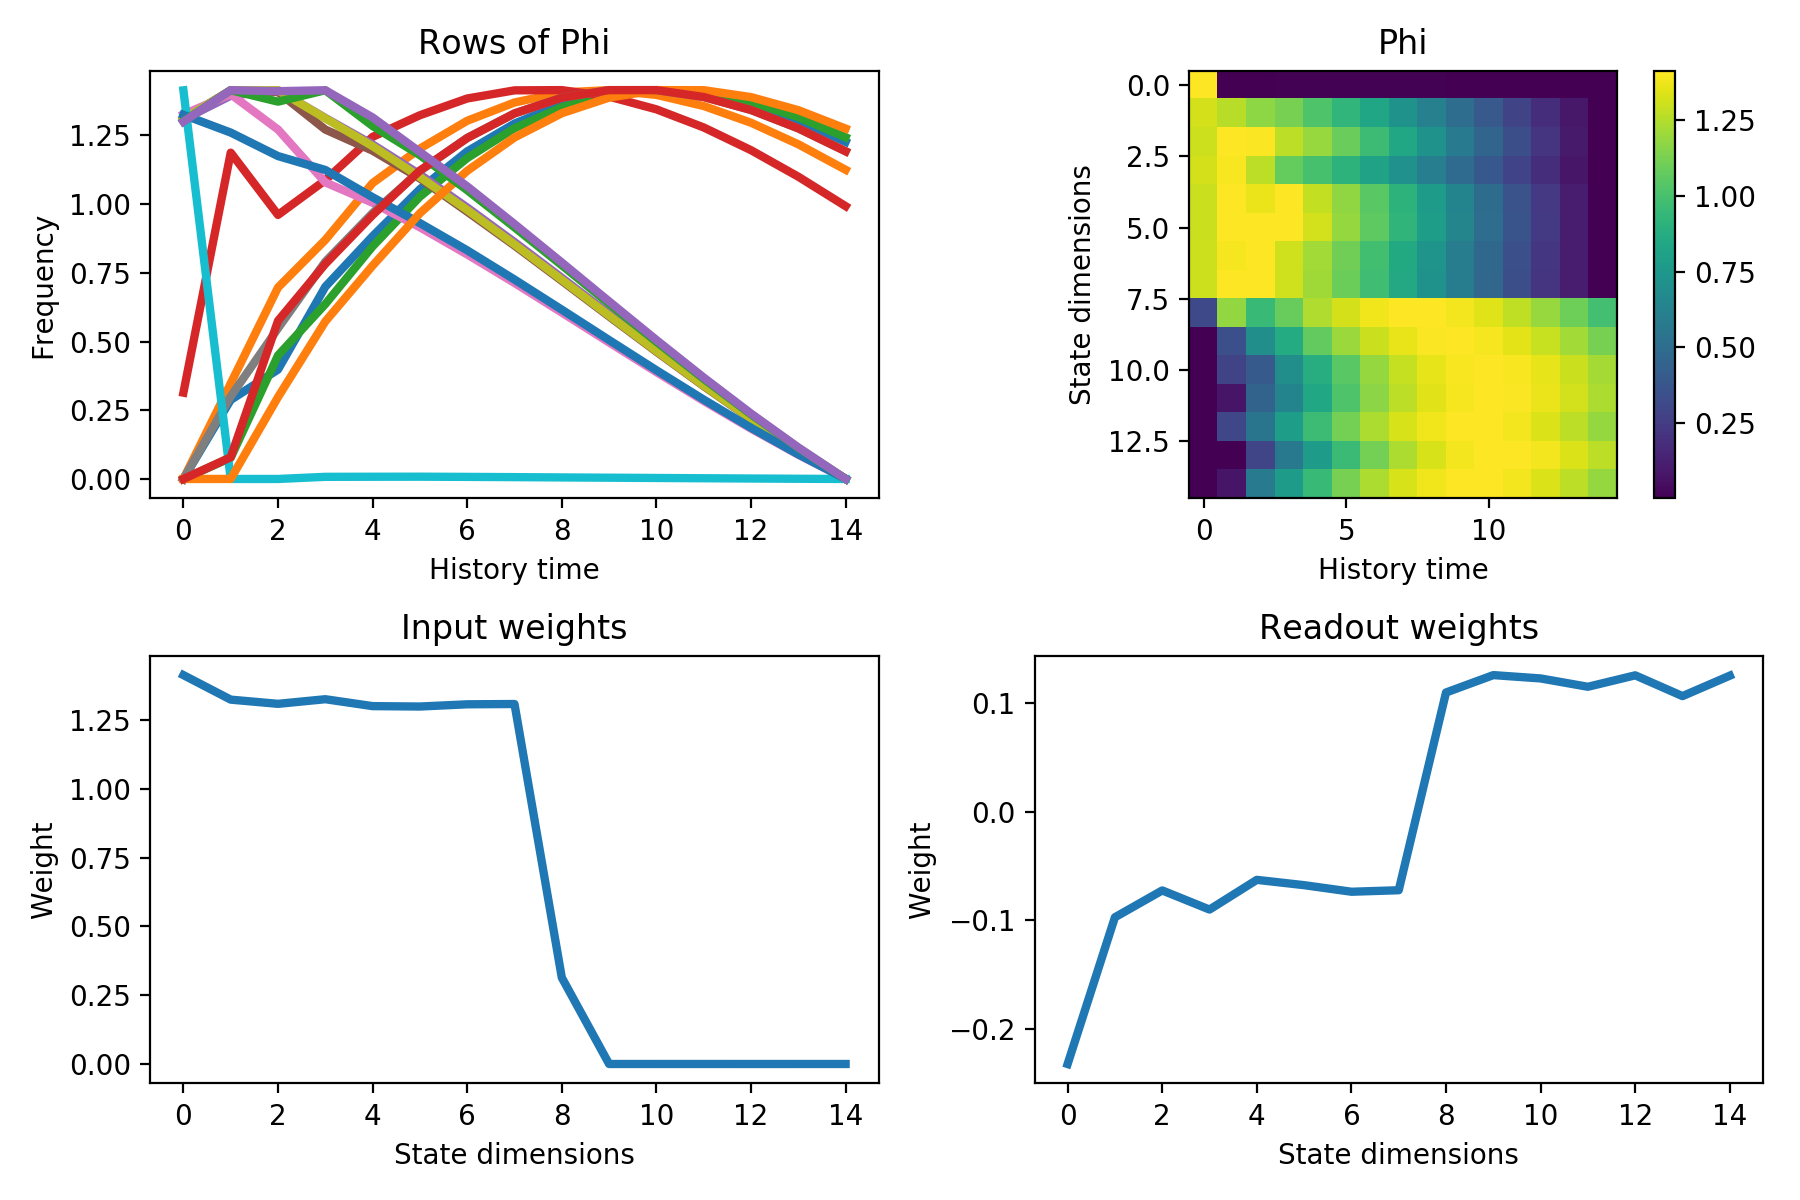

In [21]:
Phi, var_readout = phi_var(A,B,C,T_D)
sort_rows = np.argsort(np.argmax(Phi.data.numpy(), 1)) # sort rows by time of maximal activity

fig, ax = plt.subplots(2,2, figsize=(9,6))
ax[0,0].plot(Phi.data.numpy().T, linewidth=3)
ax[0,0].set_title("Rows of Phi")
ax[0,0].set_xlabel("History time")
ax[0,0].set_ylabel("Frequency")

ig = ax[0,1].imshow(Phi.data.numpy()[sort_rows,:])
ax[0,1].set_title("Phi")
ax[0,1].set_xlabel("History time")
ax[0,1].set_ylabel("State dimensions")
                   
plt.colorbar(ig, ax=ax[0,1])
ax[1,0].plot(B.data.numpy()[sort_rows,:], linewidth=3)
ax[1,0].set_title("Input weights")
ax[1,0].set_xlabel("State dimensions")
ax[1,0].set_ylabel("Weight")
                   
ax[1,1].plot(C.data.numpy().T[sort_rows,:], linewidth=3)
ax[1,1].set_title("Readout weights")
ax[1,1].set_xlabel("State dimensions")
ax[1,1].set_ylabel("Weight")

fig.tight_layout()

## Eigendecomposition of dyanmics $A$

Note for example the stable dynamics in the eigendecomposition.

<IPython.core.display.Javascript object>


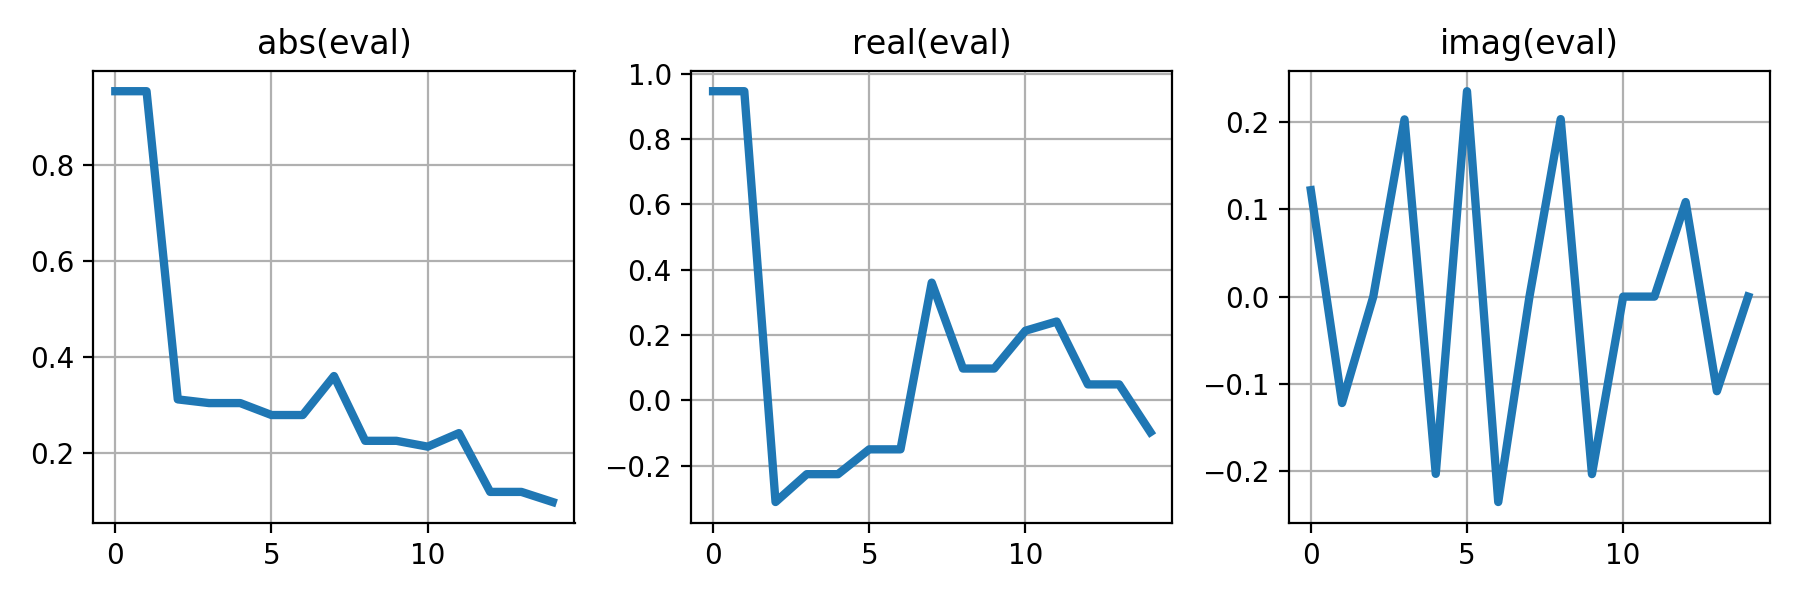

In [22]:
evalues, evectors = np.linalg.eig(A.data.numpy())
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot(np.abs(evalues), linewidth=3)
ax[0].set_title("abs(eval)")
ax[0].grid()
ax[1].plot(np.real(evalues), linewidth=3)
ax[1].set_title("real(eval)")
ax[1].grid()
ax[2].plot(np.imag(evalues), linewidth=3)
ax[2].set_title("imag(eval)")
ax[2].grid()
fig.tight_layout()

## Singular value decomposition of $\Phi$ (Figure 5F)

<IPython.core.display.Javascript object>


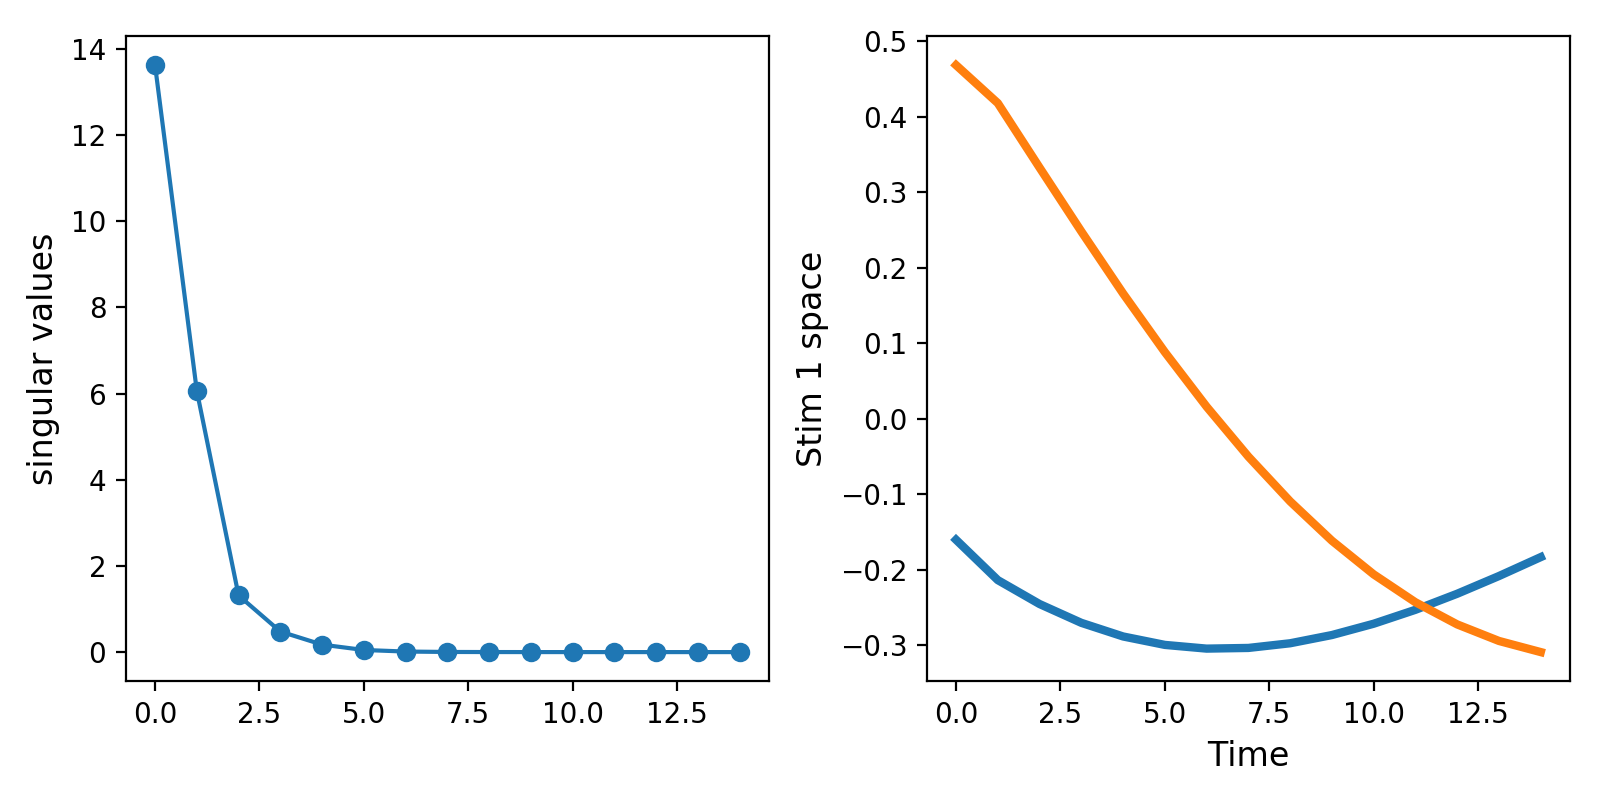

In [23]:
u,s,v = torch.svd(Phi)
fig, ax = plt.subplots(1,2, figsize=(8,4))
#ax[0].imshow(v.t().data.numpy())
ax[0].plot(s.data.numpy(), '-o')
ax[0].set_ylabel("singular values", fontsize=12)
ax[1].plot((v[:,0].data.numpy()), linewidth=3)
ax[1].plot((v[:,1].data.numpy()), linewidth=3)
ax[1].set_ylabel("Stim 1 space", fontsize=12)
ax[1].set_xlabel("Time", fontsize=12)
fig.tight_layout()

## Figure 5G

<IPython.core.display.Javascript object>


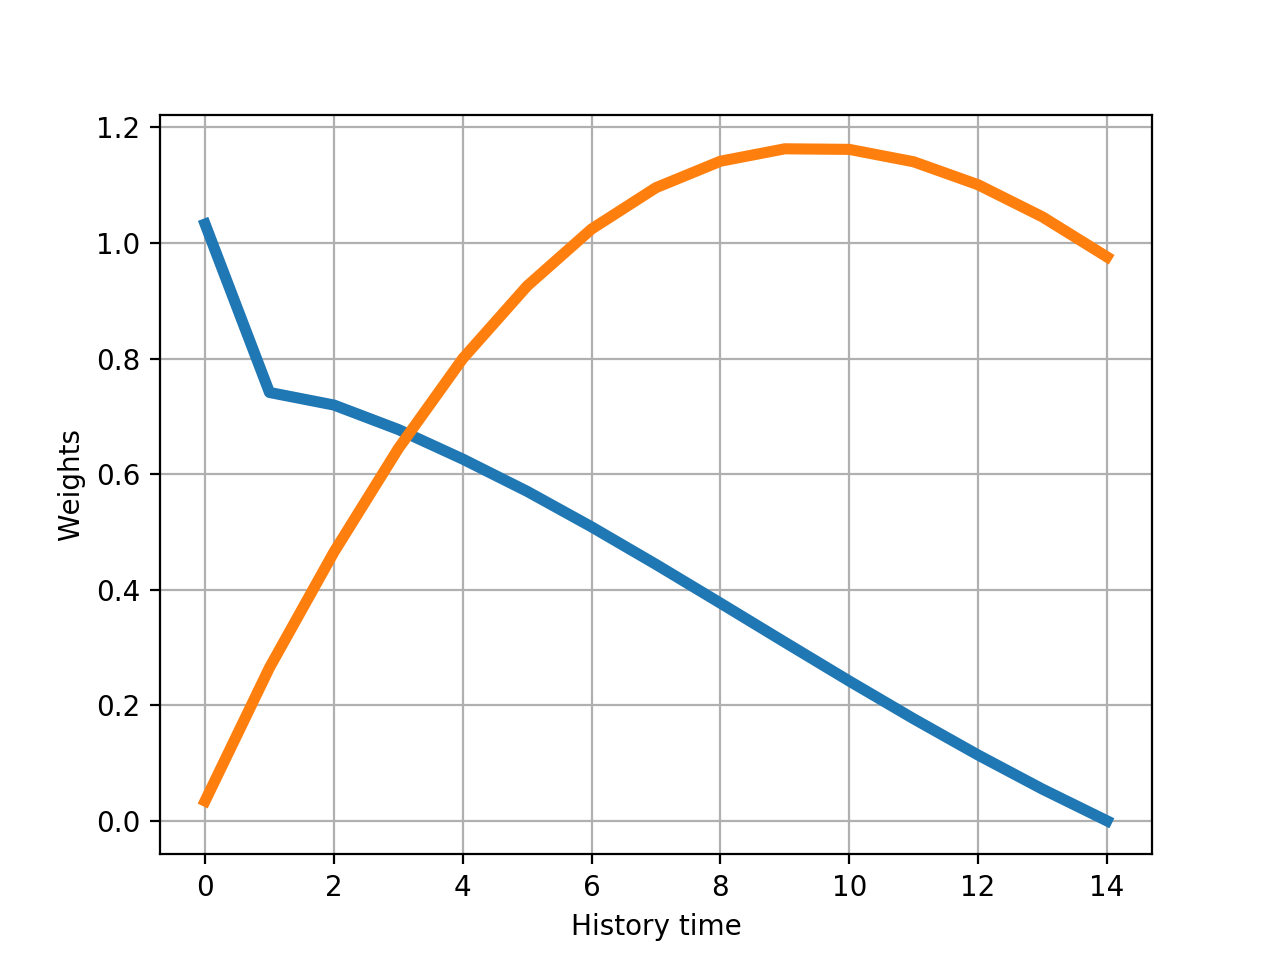

Text(0, 0.5, 'Weights')

In [24]:
plt.figure()
plt.plot(-C.clamp(-10,0).mm(Phi).data.numpy().T, linewidth=4)
plt.plot(C.clamp(0).mm(Phi).data.numpy().T, linewidth=4)
plt.grid()
plt.xlabel("History time")
plt.ylabel("Weights")

# Generate trial trajectories to compare with neural trajectories

The following cell generates model trajectories. Trajectories are stored in the tensor X_trials.

In [29]:
np.random.seed(1)

# because we scale frequencies positively and negatively we need twice the number of state dimensions:
r_dim = 2*N_z 

# Number of trials for each trial type.
n_trials = 10
f_pairs = np.array([[1.,0.5], [1.,1.5], [2.,1.5], [2.,2.5], 
                    [3.,2.5], [3.,3.5], [4.,3.5], [4.,4.5], 
                    [5.,4.5], [5.,5.5], [6.,5.5], [6.,6.5]]) * 3

n_stim = len(np.unique(f_pairs[:,0])) # number of f_1 values used
n_dec = 2 # number of decision conditions (i.e., left, right)

simul_time = T_D+5

X_trials = np.zeros((r_dim,n_stim,n_dec,n_trials,simul_time)) 

for trial in range(n_trials):

    for fi, f_pair in enumerate(f_pairs):
        
        if f_pair[0] - f_pair[1] >= 0:
            dec = 0
        else:
            dec = 1
            
        fmin = f_pairs.min()
        fmax = f_pairs.max()

        f1 = f_pair[0]
        f1pos = 0.4 + (f1 - fmin)
        f1neg = 0.4 + (fmax - f1)

        f2 = f_pair[1]
        f2pos = 0.4 + (f2 - fmin)
        f2neg = 0.4 + (fmax - f2)

        Xpn = [] 
        for f1, f2 in [(f1pos, f2pos), (f1neg, f2neg)]:
            X_ = sim_1_trial(simul_time, stim_list, [f1, f2], 
                             A.data.numpy(), B.data.numpy()[:,0], N_z, sig_trans, decay=True)
            Xpn.append(X_)

        X_ = np.vstack(Xpn)
        
        for t in range(simul_time):
            
            f1i = np.where(np.unique(f_pairs[:,0]) == f_pair[0])[0][0]
            
            X_trials[:, f1i, dec, trial, t] = X_[:,t]

Xr = X_trials.mean(axis=3) # mean rates     

## The frequency scaling function

Each frequency $f_1$ or $f_2$ is scaled positively (blue line) as well as negatively (orange line)

<IPython.core.display.Javascript object>


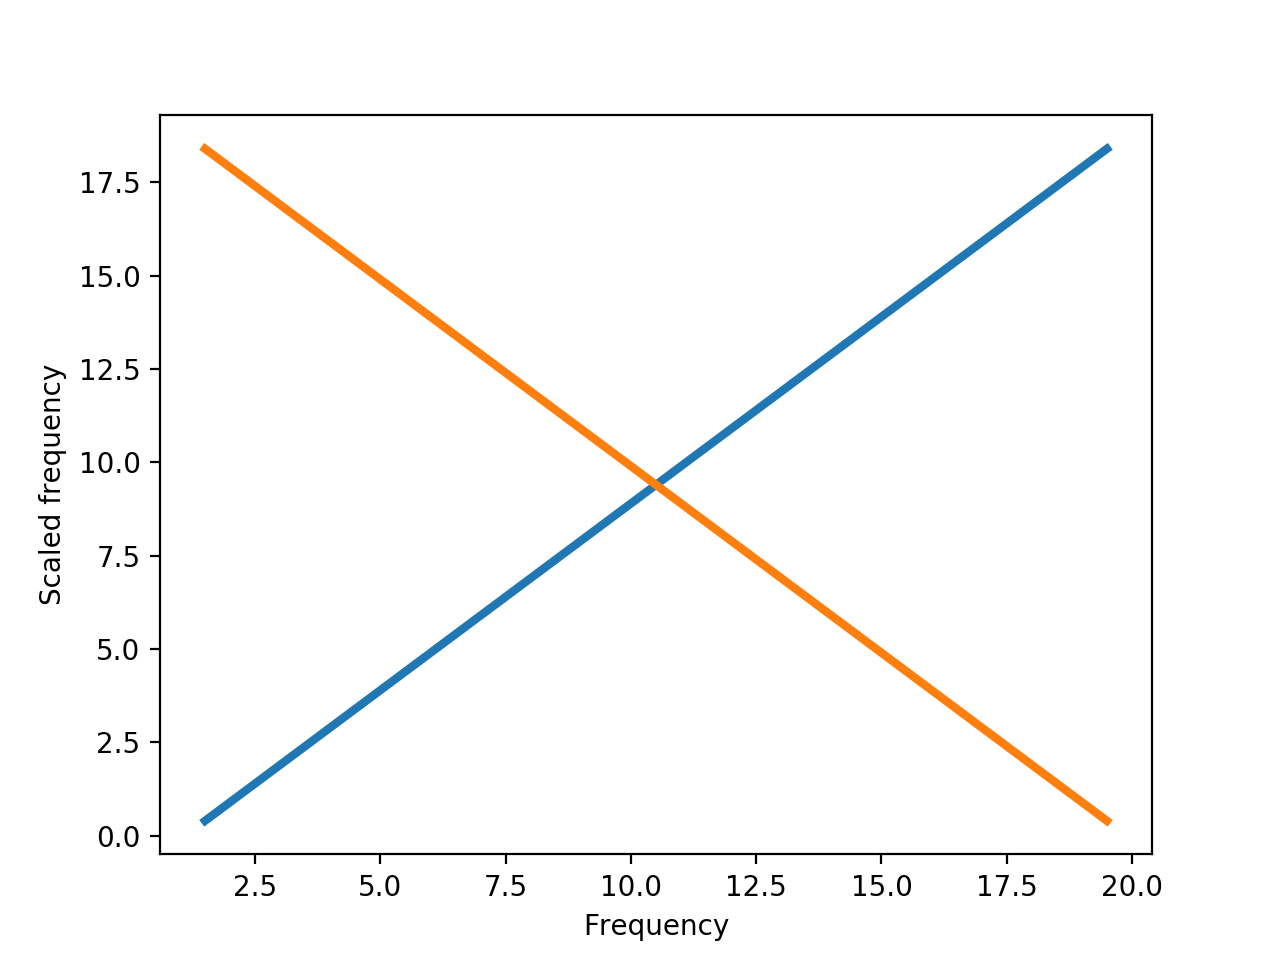

Text(0, 0.5, 'Scaled frequency')

In [30]:
plt.figure()
f1 = np.linspace(fmin,fmax,10)
plt.plot(f1, 0.4 + (f1 - fmin), linewidth=3)
plt.plot(f1, 0.4 + (fmax - f1), linewidth=3)
plt.xlabel("Frequency")
plt.ylabel("Scaled frequency")

## Plot state dimension PSTHs

<IPython.core.display.Javascript object>


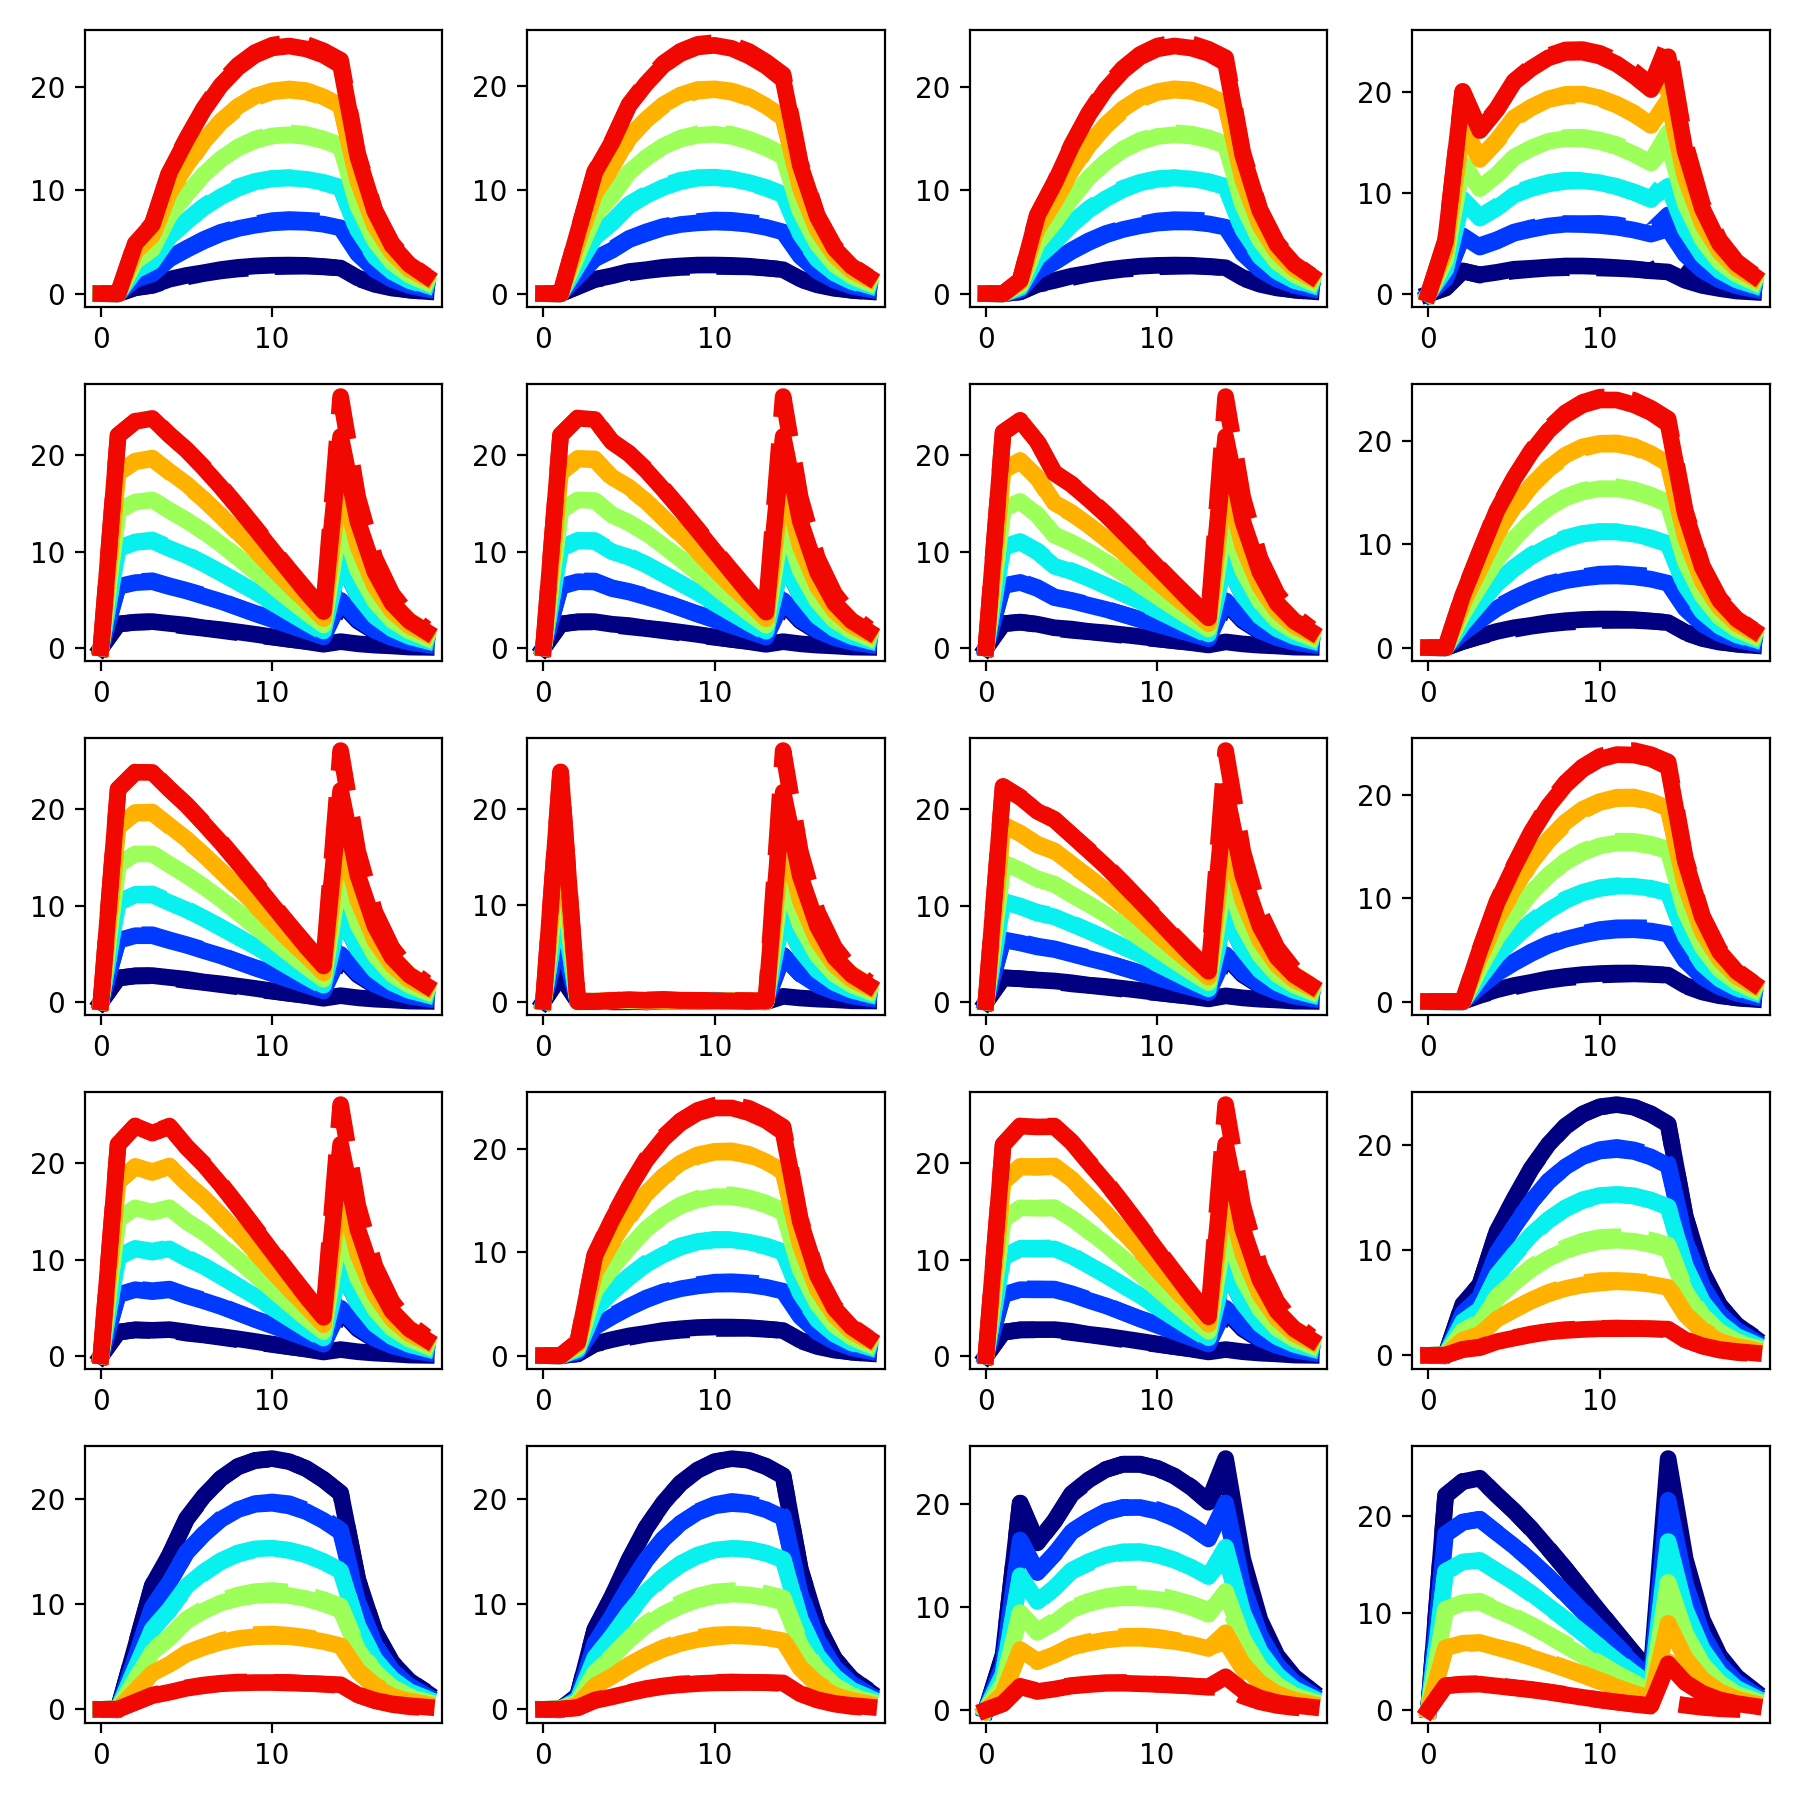

In [31]:
cm = plt.get_cmap('jet')

nrow = 5
ncol = 4

fig, ax = plt.subplots(nrow,ncol, figsize=(9,9))
cols = np.linspace(0,0.9,n_stim)

for ni in range(nrow*ncol):
    for si in range(Xr.shape[1]):
        for ci in range(Xr.shape[2]):
            ax.flat[ni].plot(Xr[ni, si, ci, :], 
                              color=cm(cols[si]), 
                              linestyle = ['-','--'][ci],
                              linewidth=6)
fig.tight_layout()